# Rebin Lidar Point Cloud and Create Depth Map

1. Takes as input a lidar point cloud .csv file
2. Recalculates the rotation and inclination angle to rebin the point cloud vertically and horizontally
3. Interpolates using nearest neighbors to fill in any blank pixels from rebinning
4. Export to depth map image

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
# Change these two variables to select file path for input and output
# Remember to include "/" at the end of the file_path
file_path = "data/13-forest/"
csv_name = "1503619206497711897-cloudpoint.csv"

df = pd.read_csv(file_path + csv_name, 
                 names = ['x', 'y', 'z', 
                          'intensity', 'ring', 'rotation', 'revolution'])

df['distance'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
df['rotation-angle'] = np.arctan2(df['x'], df['y']) + np.pi
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])

# img_height is the default number of lasers
# img_width is the default total number of points divided by the number of lasers
img_height = 64
img_width = 2088

## Vertical binning

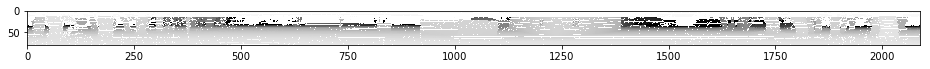

In [15]:
# changing new_height determines the number of vertical bins in the histogram
new_height = 80

bin_size = img_height
img_height = new_height

# calculate histogram for inclination angle
df['inclination-angle'] = np.arctan2(df['z'], df['distance'])
df_inclination_arr = df['inclination-angle'].as_matrix()
hist, bin_edges = np.histogram(df_inclination_arr, bins = img_height - 1)

df.sort_values(['rotation-angle'], inplace = True)
depth_img = np.zeros((img_width, img_height))

for i in range(img_width):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice['distance'].as_matrix()
    pixel_bin_arr = np.digitize(df_rot_slice['inclination-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_vert_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_vert_loc] = df_rot_slice_arr[j]
    
depth_img = np.rot90(depth_img)

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'upper', vmax=50)

fig.savefig(file_path + "depth-map-vert-binned.png", dpi = 300)

### Nearest Neighbors Interpolation

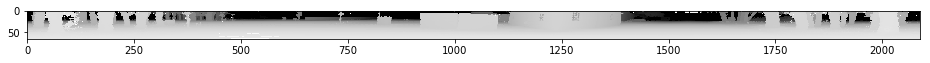

In [16]:
mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        # skip if not an empty pixel
        if (depth_img[x][y] != 0):
            continue
        
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = depth_img[x_start + x_n][y_start + y_n]
                if (pixel != 0):
                    nn_arr.append(pixel)

        if (len(nn_arr) <= 1):
            if (x < img_height/2):
                mapping[(x, y)] = 100
            continue
        # fill empty pixel with average of filled in neighbors
        nn_avg = sum(nn_arr)/len(nn_arr)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping:
    depth_img[x][y] = mapping[(x, y)]

# Cut off top of image
cut_off = 14
depth_img = depth_img[cut_off:][:]

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'upper', vmax=50)

fig.savefig(file_path + "depth-map-vert-interpolated.png", dpi = 300)

## Horizontal Binning

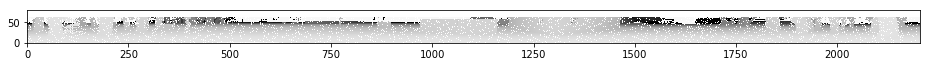

In [17]:
# changing new_width determines the number of horizontal bins in the histogram
new_width = 2204

bin_size = img_width
img_width = new_width

# Calculate inclination angle of each ring
df.sort_values(['ring'], inplace = True);

for i in range(img_height):
    df_laser_copy = df.iloc[img_width * i : img_width * (i + 1)].copy()
    laser_mean = df_laser_copy['inclination-angle'].mean()
    df.loc[df.index[bin_size * i : bin_size * (i + 1)], 
           'inclination-angle'] = laser_mean

# calculate histogram for rotation angle
df_rotation_arr = df['rotation-angle'].as_matrix()
hist, bin_edges = np.histogram(df_rotation_arr, bins = img_width - 1)

df.sort_values(['inclination-angle'], inplace = True)

depth_img = np.zeros((img_height, img_width))

for i in range(img_height):
    df_rot_slice = df.iloc[bin_size * i : bin_size * (i + 1)].copy()
    df_rot_slice_arr = df_rot_slice['distance'].as_matrix()
    pixel_bin_arr = np.digitize(df_rot_slice['rotation-angle'], bin_edges)

    for j in range(len(pixel_bin_arr)):
        pixel_horiz_loc = pixel_bin_arr[j] - 1
        depth_img[i][pixel_horiz_loc] = df_rot_slice_arr[j]

        
fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'lower', vmax=50)

fig.savefig(file_path + "depth-map-horiz-binned.png", dpi = 300)

### Nearest Neighbors Interpolation

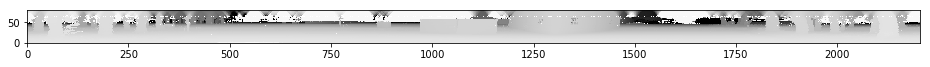

In [18]:
mapping = {}
# number of nearest point neighbors
# i.e. radius of 1 represents a 3x3 grid of nearest pixels for the middle pixel
nn_radius = 1

for x in range(nn_radius, depth_img.shape[0] - nn_radius):
    for y in range(nn_radius, depth_img.shape[1] - nn_radius):
        # find all empty pixels
        if (depth_img[x][y] != 0):
            continue
        
        nn_arr = []
        x_start = x - nn_radius
        y_start = y - nn_radius
        
        # find out nearest neighbors' depths
        for x_n in range(2 * nn_radius + 1):
            for y_n in range(2 * nn_radius + 1):
                pixel = depth_img[x_start + x_n][y_start + y_n]
                if (pixel != 0):
                    nn_arr.append(pixel)

        next_nn_radius = nn_radius
        while (len(nn_arr) == 0):
            next_nn_radius += 1;
            x_start = x - next_nn_radius
            y_start = y - next_nn_radius
            
            if (x_start < 0):
                x_start = 0
            if (y_start < 0):
                y_start = 0

            # find out nearest neighbors' depths
            for x_n in range(2 * next_nn_radius + 1):
                for y_n in range(2 * next_nn_radius + 1):
                    if (x_start + x_n >= depth_img.shape[0]):
                        continue
                    if (y_start + y_n >= depth_img.shape[1]):
                        continue
                    pixel = depth_img[x_start + x_n][y_start + y_n]
                    if (pixel != 0):
                        nn_arr.append(pixel)
        
        if (len(nn_arr) <= 2):
            if (x < img_height/2):
                mapping[(x, y)] = 100
            continue
        # fill empty pixel with average of filled in neighbors
        nn_avg = sum(nn_arr)/len(nn_arr)
        mapping[(x, y)] = nn_avg
        
for x, y in mapping:
    depth_img[x][y] = mapping[(x, y)]

fig, ax = plt.subplots(figsize=(16, 4))
ax.imshow(depth_img, cmap='binary', origin = 'lower', vmax=50)

fig.savefig(file_path + "depth-map-horiz-interpolated.png", dpi = 300)